## Bayesian Logistic Regression for IMDB 50K Dataset

### Data Pre-Processing

Removing rare/stop words, applying bag-of-words vector representation to words in review using tokenizers (tf-idf)

In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

imdb = pd.read_csv("IMDB Dataset.csv")
imdb.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [2]:
imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#### Remove Stop Words and other Rare Words

In [3]:
#list of stopwords from NLTK
# stopword_list=nltk.corpus.stopwords.words('english')

#remove HTML tags
def strip_html(html_text: str):
    return BeautifulSoup(html_text).get_text()

#make sure to add more cleaning (remove punctuation, )
def clean_review(review: str):
    return strip_html(review)

#clean each review in dataset
imdb.review.apply(clean_review)

#tags should be removed from the 2nd review
imdb.head(3)

/Users/seichang/miniconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


#### Split training dataset

80% training (40K), 20% test split (10K)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(imdb.review, imdb.sentiment, test_size=0.2, random_state=42)
print("{} {}\n{} {}".format(
    X_train.shape,
    y_train.shape,
    X_test.shape,
    y_test.shape))

(40000,) (40000,)
(10000,) (10000,)


#### Term Frequency-Inverse Document Frequency (TF-IDF)

Provides additional information on how important the word is for statistical analysis

TF-IDF = TF*IDF
- TF = (# occurrences of term `t` in review)/total # words in review). Measures how frequently `t` appears in the review 
- IDF = log_((# documents)/(# documents with term `t`)). Measures how important `t` is (if more frequent among documents, less important)

Principal Component Analysis
- dimensionality reduction to reduce feature size (from 90K to 5K components)
- `TruncatedSVD`: works on sparse data

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#initialize TF-IDF Vectorizer (no l1/l2 normalization) and pca dimensionality reduction
tf_idf = TfidfVectorizer(norm=None, ngram_range=(1,1))
pca = TruncatedSVD(n_components=5000)

#fit vocabulary on training dataset and transform
#NOTE: fit_transform equivalent to using fit() then transform()
X_train = tf_idf.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

#use vocabulary to transform test dataset
X_test = tf_idf.transform(X_test)
X_test = pca.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(40000, 5000)
(10000, 5000)


In [6]:
from sklearn.preprocessing import LabelBinarizer

#vectorize dependent binary variable y
lb=LabelBinarizer()

#if positive, output = 1
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

### Stochastic MAP Estimation

Performs stochastic gradient ascent by taking a random minibatch from the training dataset per iteration.

In [9]:
from IPython.lib.display import Tuple
from numpy.random import randint, sample
from scipy.sparse import csr
from scipy.special import expit
from sklearn.utils.fixes import scipy
from scipy.sparse import csr_matrix
from sklearn.metrics._classification import log_loss, accuracy_score

def get_log_loss(X, beta, y_true):
    #combine input with coefficients to get prediction
    y_pred = expit(X @beta)

    #dim of prediction and truth should be equal
    assert(y_pred.shape == y_true.shape)

    #calculate average of log likelihoods
    return log_loss(y_true, y_pred, labels=[0,1])

def get_accuracy(X, beta, y_true):
    #combine input with coefficients to get prediction
    y_pred = expit(X @ beta)

    # formulate decision
    for i, y in enumerate(y_pred):
        y_pred[i] = int(y > 0.5)

    #dim of prediction and truth should be equal
    assert(y_pred.shape == y_true.shape)

    #calculate average of log likehoods
    return accuracy_score(y_true, y_pred)


def stochastic_regression_map(lamb: float, X: csr_matrix, X_test: csr_matrix, y: np.ndarray, y_test: np.ndarray, l_rate: float, batch_size: int, max_iters: int, train_stat: str):
    """Stochastic gradient ascent for Bayesian Logisitc MAP

    Args:
        lamb (float): prior coefficient for L2 regularization
        X (csr_matrix): input training dataset
        X_test (csr_matrix): input testing dataset
        y (np.ndarray): output testing dataset
        y_test (np.ndarray): output testing dataset
        l_rate (float): learning rate, controls size of each gradient step
        batch_size (int): _description_
        max_iters (int): maximum number of iterations to run gradient descent on
        train_stat (str): determine which sklearn stat to fetch (accuracy or loss)

    Returns:
        (beta, sgd_stats) : (1) final trained weights, (2) array of sklearn stats obtained per iteration
    """

    #extract dimensions of X 
    num_samples, num_features = X.shape #[N x P]

    #initialize beta as 0 coefficients for features
    beta = np.zeros((num_features, 1)) #[P x 1]

    #use max_iters to control number of gradient steps
    t = 1

    #array to keep track and plot losses during SGD training
    sgd_stats = []

    while t <= max_iters:
        #fetch random batch of data
        sample_idx = randint(0, num_samples, batch_size)
        y_sample = y[sample_idx] #[B x 1]
        X_sample = X[sample_idx] #[B x P]
        
        #calculate predicted expectation -> logistic_fn(beta * x_i)
        y_pred = expit(X_sample @ beta)
        assert(y_pred.shape == y_sample.shape)

        #store out of sample log likelihood per iteration into sgd_losses
        if train_stat == "accuracy":
            sgd_stats.append(get_accuracy(X_test, beta, y_test))
        else:
            sgd_stats.append(get_log_loss(X_test, beta, y_test))

        #calculate gradient (regularization + grad scaled up by num_samples)
        grad = (-lamb*beta).T + num_samples/batch_size*((y_sample - y_pred).T @ X_sample)

        #perform gradient step
        beta = beta + l_rate/t*grad.T
        t += 1
    
    #gradient ascent finished, return coefficient
    return (beta, sgd_stats)

In [12]:
#perform stochastic gradient ascent (sanity check)
from matplotlib.pyplot import xlabel, ylabel
test_iters = 500

beta, sgd_stats = stochastic_regression_map(
    lamb=0.4, 
    X=X_train, 
    X_test=X_test,
    y=y_train, 
    y_test=y_test,
    l_rate=0.1, 
    batch_size=10,
    max_iters=test_iters,
    train_stat="accuracy")

Text(0.5, 1.0, 'Out of Sample Loss vs Training Iteration')

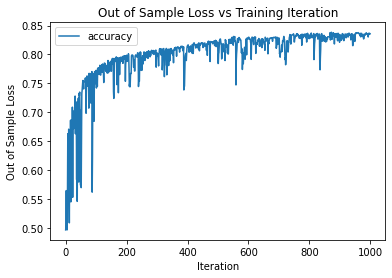

In [21]:
plt.plot(sgd_stats, label="accuracy")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Out of Sample Accuracy")
plt.title("Out of Sample Accuracy vs Training Iteration")

### Tuning Hyperparameters: Regularizer, Learning Rate, and Batch Size

training completed for 0.1
final testing accuracy after 1000 iterations: 0.7563
training completed for 0.5
final testing accuracy after 1000 iterations: 0.7529
training completed for 1
final testing accuracy after 1000 iterations: 0.7534
training completed for 3
final testing accuracy after 1000 iterations: 0.7883
training completed for 5
final testing accuracy after 1000 iterations: 0.8413


Text(0.5, 1.0, 'Out of Sample Accuracy vs Training Iteration')

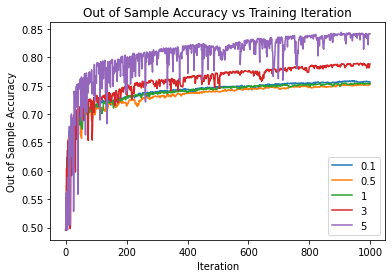

In [33]:
#L2 REGULARIZATION (LAMBDA)

test_iters = 1000

#tuning regularizer
for test_lamb in [0.1, 0.5, 1, 3, 5]:
    beta, sgd_stats = stochastic_regression_map(
    lamb=test_lamb, 
    X=X_train, 
    X_test=X_test,
    y=y_train, 
    y_test=y_test,
    l_rate=0.1, 
    batch_size=10,
    max_iters=test_iters,
    train_stat="accuracy")
    plt.plot(sgd_stats, label=str(test_lamb))
    print("training completed for " + str(test_lamb))
    print("final testing accuracy after {} iterations: {}".format(train_iters, sgd_stats[-1]))
    
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Out of Sample Accuracy")
plt.title("Out of Sample Accuracy vs Training Iteration")

training completed for 1e-05
final testing accuracy after 1000 iterations: 0.7253
training completed for 0.0001
final testing accuracy after 1000 iterations: 0.747
training completed for 0.001
final testing accuracy after 1000 iterations: 0.7484
training completed for 0.01
final testing accuracy after 1000 iterations: 0.7614
training completed for 0.1
final testing accuracy after 1000 iterations: 0.8361


Text(0.5, 1.0, 'Out of Sample Accuracy vs Training Iteration')

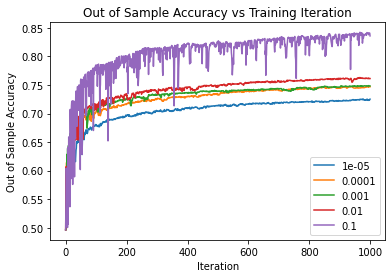

In [28]:
#LEARNING RATE
train_iters = 1000
train_lamb = 5
train_batch = 10

#tuning regularizer
for learning_rate in [1e-5, 1e-4, 1e-3, 1e-2, 0.1]:
    beta, sgd_stats = stochastic_regression_map(
    lamb=train_lamb, 
    X=X_train, 
    X_test=X_test,
    y=y_train, 
    y_test=y_test,
    l_rate=learning_rate, 
    batch_size=train_batch,
    max_iters=train_iters,
    train_stat="accuracy")
    plt.plot(sgd_stats, label=str(learning_rate))
    print("training completed for " + str(learning_rate))
    print("final testing accuracy after {} iterations: {}".format(train_iters, sgd_stats[-1]))
    
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Out of Sample Accuracy")
plt.title("Out of Sample Accuracy vs Training Iteration")

training completed for 1
final testing accuracy after 1000 iterations: 0.7466
training completed for 4
final testing accuracy after 1000 iterations: 0.8143
training completed for 7
final testing accuracy after 1000 iterations: 0.8112
training completed for 10
final testing accuracy after 1000 iterations: 0.8365
training completed for 13
final testing accuracy after 1000 iterations: 0.8392


Text(0.5, 1.0, 'Out of Sample Accuracy vs Training Iteration')

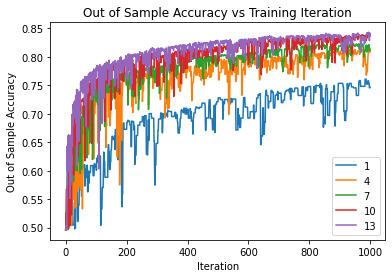

In [32]:
#BATCH SIZE
train_iters = 1000
learning_rate = 0.1
train_lamb = 5

for batch_train in range(1, 15, 3):
    beta, sgd_stats = stochastic_regression_map(
    lamb=train_lamb, 
    X=X_train, 
    X_test=X_test,
    y=y_train, 
    y_test=y_test,
    l_rate=learning_rate, 
    batch_size=batch_train,
    max_iters=train_iters,
    train_stat="accuracy")
    plt.plot(sgd_stats, label=str(batch_train))
    print("training completed for " + str(batch_train))
    print("final testing accuracy after {} iterations: {}".format(train_iters, sgd_stats[-1]))

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Out of Sample Accuracy")
plt.title("Out of Sample Accuracy vs Training Iteration")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


training completed for 13
final testing accuracy after 1000 iterations: 0.8729


Text(0.5, 1.0, 'Out of Sample Accuracy vs Training Iteration')

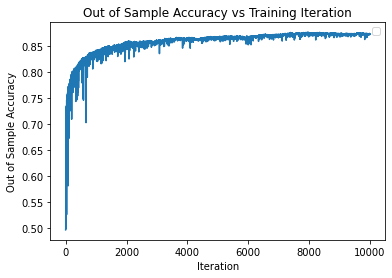

In [34]:
#BATCH SIZE
train_iters = 20000
learning_rate = 0.1
train_lamb = 5
batch_train = 15

beta, sgd_stats = stochastic_regression_map(
    lamb=train_lamb, 
    X=X_train, 
    X_test=X_test,
    y=y_train, 
    y_test=y_test,
    l_rate=learning_rate, 
    batch_size=batch_train,
    max_iters=train_iters,
    train_stat="accuracy")

plt.plot(sgd_stats)
print("training completed for " + str(batch_train))
print("final testing accuracy after {} iterations: {}".format(train_iters, sgd_stats[-1]))

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Out of Sample Accuracy")
plt.title("Out of Sample Accuracy vs Training Iteration")

In [43]:
from sklearn.linear_model import SGDClassifier

#create SGD Classifier
sgd_logistic = SGDClassifier(loss="log_loss", penalty="l2", alpha=0.4, max_iter=1000, random_state=42)
sgd_logistic.fit(X_train, np.ravel(y_train))

y_predict = sgd_logistic.predict(X_test)
accuracy_score(y_test, y_predict)

0.8883